# DEEP NEURAL NETWORKS - ASSIGNMENT 2: CNN FOR IMAGE CLASSIFICATION

## Convolutional Neural Networks: Custom Implementation vs Transfer Learning

STUDENT INFORMATION (REQUIRED - DO NOT DELETE)

BITS ID: 2025AA05360

Name: PAUL J PALATHINGAL

Email: 2025aa05360@wilp.bits-pilani.ac.in

Date: 02-02-2026

In [32]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import time
import json
import os


#!pip install kagglehub
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("salader/dogsvscats")

#print("Path to dataset files:", path)

In [33]:
# Deep learning frameworks (choose Keras or PyTorch)
# For image processing
from PIL import Image
######### import cv2

### 1.1 Dataset Selection and Loading

Load dataset

In [34]:
# REQUIRED: Fill in these metadata fields
dataset_name = "Microsoft Cats vs Dogs"
dataset_source = "https://www.kaggle.com/datasets/salader/dogsvscats"

# Path to the dataset locally downloaded
dataset_path = r"C:\learning_misc\catsvsdogs"
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")

train_cat_path = os.path.join(train_path, "cats")
train_dog_path = os.path.join(train_path, "dogs")
test_cat_path = os.path.join(test_path, "cats")
test_dog_path = os.path.join(test_path, "dogs")

# Count image files
train_cats_count = len([f for f in os.listdir(train_cat_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
train_dogs_count = len([f for f in os.listdir(train_dog_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
test_cats_count = len([f for f in os.listdir(test_cat_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
test_dogs_count = len([f for f in os.listdir(test_dog_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

# Calculate totals
train_total = train_cats_count + train_dogs_count
test_total = test_cats_count + test_dogs_count
total_samples = train_total + test_total

n_samples = total_samples   # Total number of images
n_classes = 2               # Number of classes
samples_per_class = f"min: {min(train_cats_count+test_cats_count, train_dogs_count+test_dogs_count)}, max: {max(train_cats_count+test_cats_count, train_dogs_count+test_dogs_count)}, avg: {(train_cats_count + test_cats_count + train_dogs_count + test_dogs_count) // 2}"

sample_img_path = os.path.join(train_cat_path, os.listdir(train_cat_path)[0])
sample_img = Image.open(sample_img_path)

# PIL returns (width, height), but we need [height, width, channels]
original_width, original_height = sample_img.size
channels = 3 if sample_img.mode == 'RGB' else 1

image_shape =  [original_height, original_width, channels]         # [height, width, channels] , there are differnt image sizes in the dataset
problem_type = "classification"





In [35]:
# Primary metric selection
primary_metric = "Accuracy"
metric_justification = "We have balanced dataset with two classes with equal samples. Accuracy is suitable metric to evaluate overall performance in this dataset."


In [36]:
print("DATASET INFORMATION")
print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Total Samples: {n_samples}")
print(f"Number of Classes: {n_classes}")
print(f"Samples per Class: {samples_per_class}")
print(f"Image Shape: {image_shape}")
print(f"Primary Metric: {primary_metric}")
print(f"Metric Justification: {metric_justification}")

DATASET INFORMATION
Dataset: Microsoft Cats vs Dogs
Source: https://www.kaggle.com/datasets/salader/dogsvscats
Total Samples: 25000
Number of Classes: 2
Samples per Class: min: 12500, max: 12500, avg: 12500
Image Shape: [374, 500, 3]
Primary Metric: Accuracy
Metric Justification: We have balanced dataset with two classes with equal samples. Accuracy is suitable metric to evaluate overall performance in this dataset.


### 1.2 Data Exploration and Visualization

- TODO: Show sample images from each class
- TODO: Plot class distribution
- TODO: Display image statistics

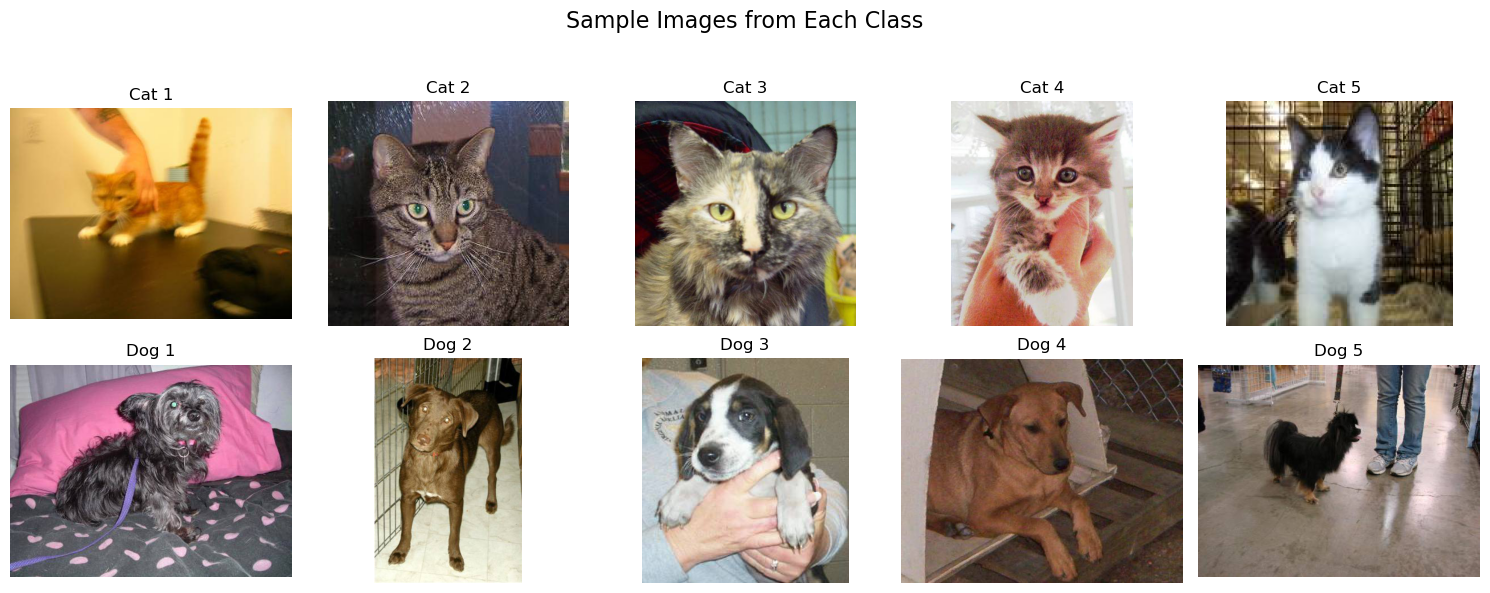

In [37]:
# Show sample images from each class
num_samples = 5                                             # Number of images to display per class
fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))   

cat_images = os.listdir(train_cat_path)[:num_samples]       
dog_images = os.listdir(train_dog_path)[:num_samples]       

for i, img_name in enumerate(cat_images):                   # getting first 5 images from cat class
    img_path = os.path.join(train_cat_path, img_name)
    img = Image.open(img_path)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Cat {i+1}")
    axes[0, i].axis('off')

for i, img_name in enumerate(dog_images):                   # getting first 5 images from dog class
    img_path = os.path.join(train_dog_path, img_name)
    img = Image.open(img_path)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Dog {i+1}")
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Cats', fontsize=14)
axes[1, 0].set_ylabel('Dogs', fontsize=14)
plt.suptitle('Sample Images from Each Class', fontsize=16)  # ploting the sample figures
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

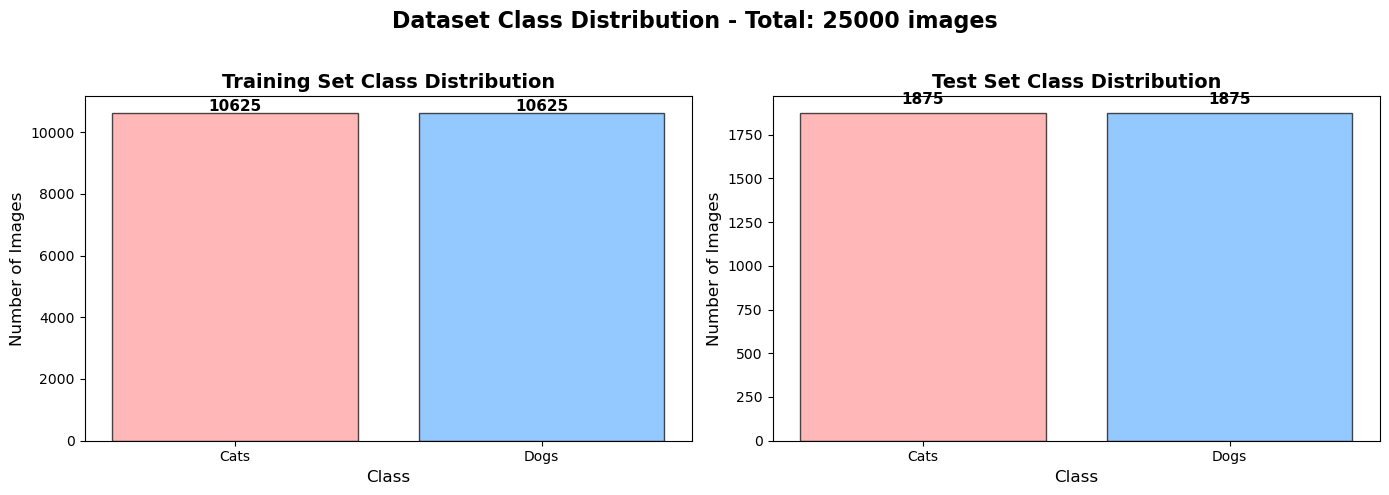


Class Distribution Summary:
Class      Train      Test       Total     
----------------------------------------
Cats       10625      1875       12500     
Dogs       10625      1875       12500     
----------------------------------------
Total      21250      3750       25000     


In [38]:
# Plot class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set distribution
train_counts = [train_cats_count, train_dogs_count]
train_labels = ['Cats', 'Dogs']
colors = ['#ff9999', '#66b3ff']

axes[0].bar(train_labels, train_counts, color=colors, edgecolor='black', alpha=0.7)
axes[0].set_title('Training Set Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Images', fontsize=12)
axes[0].set_xlabel('Class', fontsize=12)
for i, count in enumerate(train_counts):
    axes[0].text(i, count + 50, str(count), ha='center', fontsize=11, fontweight='bold')

# Test set distribution
test_counts = [test_cats_count, test_dogs_count]
test_labels = ['Cats', 'Dogs']

axes[1].bar(test_labels, test_counts, color=colors, edgecolor='black', alpha=0.7)
axes[1].set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Images', fontsize=12)
axes[1].set_xlabel('Class', fontsize=12)
for i, count in enumerate(test_counts):
    axes[1].text(i, count + 50, str(count), ha='center', fontsize=11, fontweight='bold')

plt.suptitle(f'Dataset Class Distribution - Total: {total_samples} images', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Print distribution summary
print("\nClass Distribution Summary:")
print(f"{'Class':<10} {'Train':<10} {'Test':<10} {'Total':<10}")
print("-" * 40)
print(f"{'Cats':<10} {train_cats_count:<10} {test_cats_count:<10} {train_cats_count + test_cats_count:<10}")
print(f"{'Dogs':<10} {train_dogs_count:<10} {test_dogs_count:<10} {train_dogs_count + test_dogs_count:<10}")
print("-" * 40)
print(f"{'Total':<10} {train_total:<10} {test_total:<10} {total_samples:<10}")

### 1.3 Data Preprocessing
- TODO: Resize images to consistent size
- TODO: Normalize pixel values
- TODO: Split into train/test (90/10 or 85/15)

In [39]:
# Train Test Data Split split
train_test_ratio = "85/15"      # 85% training, 15% testing , as per original dataset split
train_samples = train_total     # Number of training samples
test_samples = test_total       # Number of test samples

In [40]:
print(f"\nTrain/Test Split: {train_test_ratio}")
print(f"Training Samples: {train_samples}")
print(f"Test Samples: {test_samples}")


Train/Test Split: 85/15
Training Samples: 21250
Test Samples: 3750


In [41]:
# Import TensorFlow/Keras for data preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set image preprocessing parameters
IMG_HEIGHT = 128  # Standard size for many pre-trained models
IMG_WIDTH = 128
BATCH_SIZE = 32

print(f"Image preprocessing configuration:")
print(f"Target size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Normalization: Pixel values will be scaled to [0, 1]")

Image preprocessing configuration:
Target size: 128x128
Batch size: 32
Normalization: Pixel values will be scaled to [0, 1]


In [42]:
# Create ImageDataGenerator for training data with normalization
# Rescale pixel values from [0, 255] to [0, 1]
train_datagen = ImageDataGenerator(
    rescale=1./255           # Normalize pixel values to [0, 1]
)

# Create ImageDataGenerator for test data with only normalization
test_datagen = ImageDataGenerator(rescale=1./255)

print("Data augmentation and normalization setup:")
print("- Training images: Normalized to [0, 1]")
print("- Test images: Normalized to [0, 1]")
print("- Using pre-split train and test folders (no validation split from training)")

Data augmentation and normalization setup:
- Training images: Normalized to [0, 1]
- Test images: Normalized to [0, 1]
- Using pre-split train and test folders (no validation split from training)


In [43]:
# Create data generators with resizing and normalization
# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize all images to 128x128
    batch_size=BATCH_SIZE,
    class_mode='categorical',              # For multi-class classification
    shuffle=True,
    seed=42
)

# Test data generator (already split in separate folder)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize all images to 128x128
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\nData generators created successfully:")
print(f"Training samples: {train_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"\nClass indices: {train_generator.class_indices}")
print(f"Number of batches - Train: {len(train_generator)}, Test: {len(test_generator)}")

Found 21250 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.

Data generators created successfully:
Training samples: 21250
Test samples: 3750

Class indices: {'cats': 0, 'dogs': 1}
Number of batches - Train: 665, Test: 118



Preprocessing verification:
Batch shape: (32, 128, 128, 3)
Labels shape: (32, 2)
Pixel value range: [0.0000, 1.0000]
Mean pixel value: 0.4587
Std pixel value: 0.2627


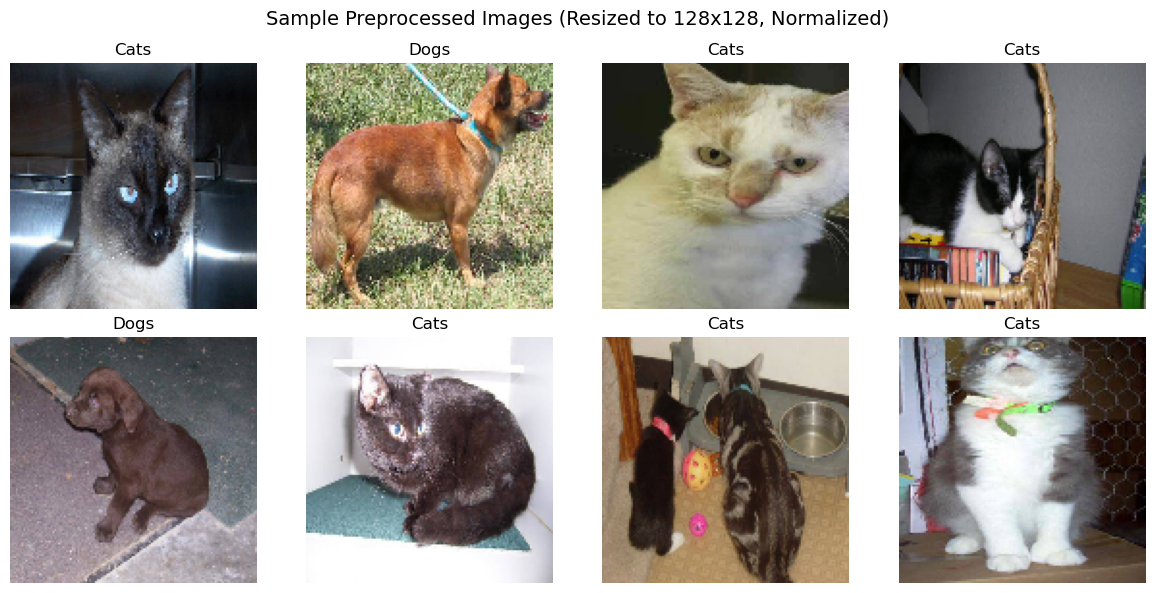

In [44]:
# Verify preprocessing by displaying a batch of processed images
sample_batch, sample_labels = next(train_generator)

print(f"\nPreprocessing verification:")
print(f"Batch shape: {sample_batch.shape}")
print(f"Labels shape: {sample_labels.shape}")
print(f"Pixel value range: [{sample_batch.min():.4f}, {sample_batch.max():.4f}]")
print(f"Mean pixel value: {sample_batch.mean():.4f}")
print(f"Std pixel value: {sample_batch.std():.4f}")

# Display sample preprocessed images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    axes[i].imshow(sample_batch[i])
    class_idx = np.argmax(sample_labels[i])
    class_name = list(train_generator.class_indices.keys())[class_idx]
    axes[i].set_title(f"{class_name.capitalize()}")
    axes[i].axis('off')

plt.suptitle(f'Sample Preprocessed Images (Resized to {IMG_HEIGHT}x{IMG_WIDTH}, Normalized)', fontsize=14)
plt.tight_layout()
plt.show()

# Reset the generator after sampling
train_generator.reset()

### 2.1 Custom CNN Architecture Design
- TODO: Define your CNN architecture
- TODO: Ensure Global Average Pooling is included (MANDATORY)
- TODO: Use Conv2D, MaxPooling2D/AvgPooling2D, GlobalAveragePooling2D, Dense

In [45]:
def build_custom_cnn(input_shape, n_classes):
    """
    Build custom CNN architecture
    
    Args:
        input_shape: tuple (height, width, channels)
        n_classes: number of output classes
    
    Returns:
        model: compiled CNN model
    """
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
    
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Fourth Convolutional Block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        
        # Global Average Pooling (MANDATORY - replaces Flatten + Dense)
        GlobalAveragePooling2D(),
        
        # Dropout for regularization
        Dropout(0.5),
        
        # Output Layer with Softmax
        Dense(n_classes, activation='softmax')
    ])
    
    return model

In [46]:
# Create model instance
custom_cnn = build_custom_cnn(image_shape, n_classes)

# Display model architecture
print("\n Custom CNN Architecture:")
custom_cnn.summary()

# Count parameters
total_params = custom_cnn.count_params()
print(f"\nTotal parameters: {total_params:,}")


 Custom CNN Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,850 (1.49 MB)

 Trainable params: 389,890 (1.49 MB)

 Non-trainable params: 960 (3.75 KB)


Total parameters: 390,850


In [47]:
# Compile model
from tensorflow.keras.optimizers import Adam

custom_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")
print(f"Optimizer: Adam (lr=0.001)")
print(f"Loss function: categorical_crossentropy")
print(f"Metrics: accuracy")

Model compiled successfully!
Optimizer: Adam (lr=0.001)
Loss function: categorical_crossentropy
Metrics: accuracy


### 2.2 Train Custom CNN

In [48]:
print("\nCUSTOM CNN TRAINING")
# Track training time
custom_cnn_start_time = time.time()


CUSTOM CNN TRAINING


In [49]:
# Train the model
EPOCHS = 20

print(f"Training for {EPOCHS} epochs...\n")

history = custom_cnn.fit(
    train_generator,
    epochs=EPOCHS,
    verbose=1
)

print("\nTraining completed!")

Training for 20 epochs...



c:\Users\jisap\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 926s 1s/step - accuracy: 0.6636 - loss: 0.6292
Epoch 2/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 1509s 2s/step - accuracy: 0.7615 - loss: 0.4928
Epoch 3/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 19758s 30s/step - accuracy: 0.8315 - loss: 0.3798
Epoch 4/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 513s 771ms/step - accuracy: 0.8728 - loss: 0.2997
Epoch 5/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 529s 795ms/step - accuracy: 0.8973 - loss: 0.2497
Epoch 6/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 539s 811ms/step - accuracy: 0.9127 - loss: 0.2116
Epoch 7/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 550s 828ms/step - accuracy: 0.9247 - loss: 0.1892
Epoch 8/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 522s 786ms/step - accuracy: 0.9357 - loss: 0.1620
Epoch 9/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 502s 755ms/step - accuracy: 0.9427 - loss: 0.1451
Epoch 10/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 587s 883ms/step - accuracy: 0.9461 - loss: 0.1364
Epoch 11/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 578s 868ms/step - accuracy: 0.9535 - loss: 0.1201
Epoch 12/20
6

In [50]:
custom_cnn_training_time = time.time() - custom_cnn_start_time

In [51]:
# REQUIRED: Track initial and final loss
custom_cnn_initial_loss = history.history['loss'][0]  # First epoch loss
custom_cnn_final_loss = history.history['loss'][-1]  # Last epoch loss

In [52]:
print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")

Training completed in 42584.98 seconds
Initial Loss: 0.6292
Final Loss: 0.0638


In [53]:
print("\nCUSTOM CNN EVALUATION")


CUSTOM CNN EVALUATION


### 2.3 Evaluate Custom CNN
- TODO: Make predictions on test set
- TODO: Calculate all 4 required metrics

In [54]:
# Make predictions on test set
print("Making predictions on test set...")
test_generator.reset()
y_pred_probs = custom_cnn.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = test_generator.classes

# Calculate all 4 metrics
custom_cnn_accuracy = accuracy_score(y_true, y_pred)
custom_cnn_precision = precision_score(y_true, y_pred, average='macro')
custom_cnn_recall = recall_score(y_true, y_pred, average='macro')
custom_cnn_f1 = f1_score(y_true, y_pred, average='macro')

print("\nMetrics calculated successfully!")

Making predictions on test set...
118/118 ━━━━━━━━━━━━━━━━━━━━ 51s 428ms/step

Metrics calculated successfully!


In [55]:
print("\nCustom CNN Performance:")
print(f"Accuracy:  {custom_cnn_accuracy:.4f}")
print(f"Precision: {custom_cnn_precision:.4f}")
print(f"Recall:    {custom_cnn_recall:.4f}")
print(f"F1-Score:  {custom_cnn_f1:.4f}")


Custom CNN Performance:
Accuracy:  0.8973
Precision: 0.9063
Recall:    0.8973
F1-Score:  0.8968


### 2.4 Visualize Custom CNN Results
- TODO: Plot training loss curve
- TODO: Plot confusion matrix
- TODO: Show sample predictions

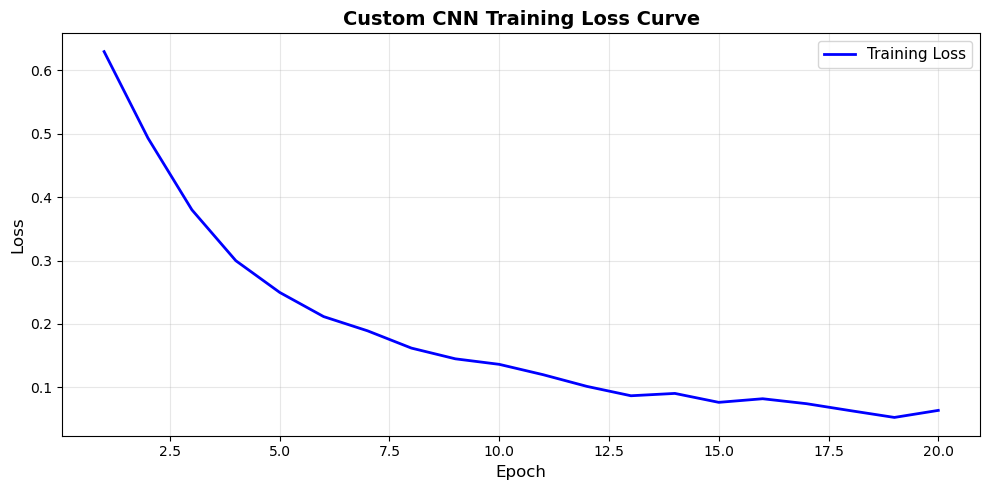


Loss decreased from 0.6292 to 0.0638
Total reduction: 0.5653


In [56]:
# Plot training loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], 'b-', linewidth=2, label='Training Loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Custom CNN Training Loss Curve', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nLoss decreased from {custom_cnn_initial_loss:.4f} to {custom_cnn_final_loss:.4f}")
print(f"Total reduction: {custom_cnn_initial_loss - custom_cnn_final_loss:.4f}")

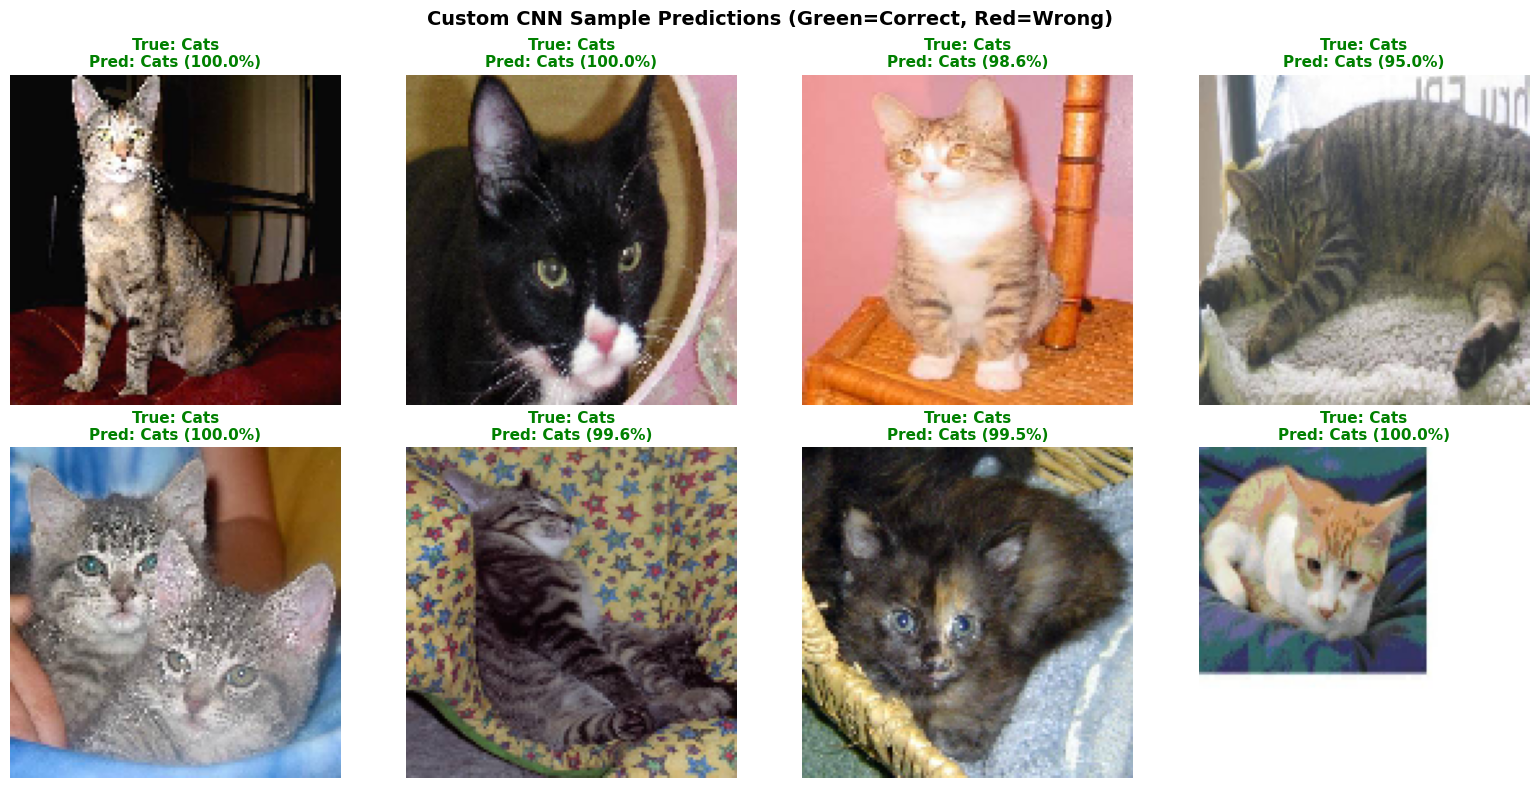


Sample batch accuracy: 30/8 correct (375.0%)


In [57]:
# Show sample predictions
# Get a batch of test images for visualization
test_generator.reset()
sample_images, sample_true_labels = next(test_generator)

# Make predictions on these samples
sample_predictions = custom_cnn.predict(sample_images, verbose=0)
sample_pred_classes = np.argmax(sample_predictions, axis=1)
sample_true_classes = np.argmax(sample_true_labels, axis=1)

# Display 8 sample predictions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

class_names = list(train_generator.class_indices.keys())

for i in range(8):
    axes[i].imshow(sample_images[i])
    
    true_label = class_names[sample_true_classes[i]]
    pred_label = class_names[sample_pred_classes[i]]
    confidence = sample_predictions[i][sample_pred_classes[i]] * 100
    
    # Color: green if correct, red if wrong
    color = 'green' if sample_true_classes[i] == sample_pred_classes[i] else 'red'
    
    axes[i].set_title(f'True: {true_label.capitalize()}\nPred: {pred_label.capitalize()} ({confidence:.1f}%)', 
                     color=color, fontweight='bold', fontsize=11)
    axes[i].axis('off')

plt.suptitle('Custom CNN Sample Predictions (Green=Correct, Red=Wrong)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print prediction statistics
correct = np.sum(sample_true_classes == sample_pred_classes)
print(f"\nSample batch accuracy: {correct}/8 correct ({correct/8*100:.1f}%)")

# Reset generator for future use
test_generator.reset()

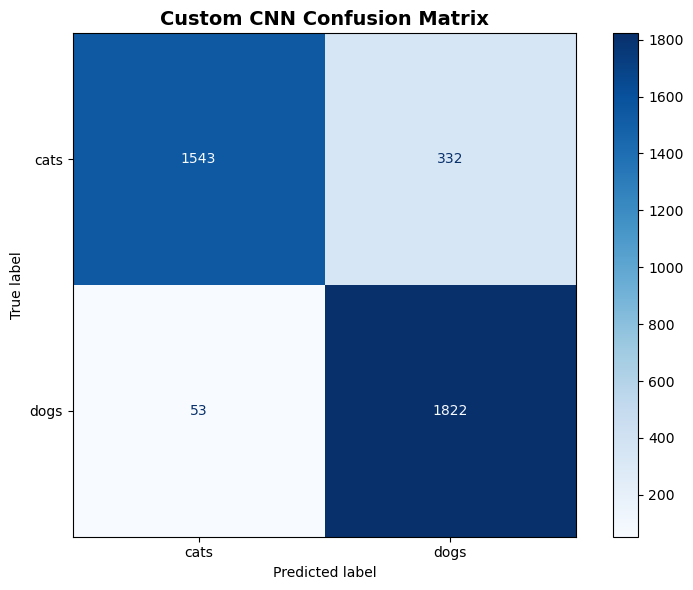


Confusion Matrix Analysis:
True Negatives (Cats as Cats): 1543
False Positives (Cats as Dogs): 332
False Negatives (Dogs as Cats): 53
True Positives (Dogs as Dogs): 1822

Total Correct Predictions: 3365/3750


In [58]:
# Plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
class_names = list(train_generator.class_indices.keys())

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Custom CNN Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print detailed confusion matrix statistics
print("\nConfusion Matrix Analysis:")
print(f"True Negatives (Cats as Cats): {cm[0, 0]}")
print(f"False Positives (Cats as Dogs): {cm[0, 1]}")
print(f"False Negatives (Dogs as Cats): {cm[1, 0]}")
print(f"True Positives (Dogs as Dogs): {cm[1, 1]}")
print(f"\nTotal Correct Predictions: {cm[0, 0] + cm[1, 1]}/{cm.sum()}")

### 3.1 Load Pre-trained Model and Modify Architecture

In [59]:
print("\n" + "="*70)
print("TRANSFER LEARNING IMPLEMENTATION")


TRANSFER LEARNING IMPLEMENTATION


In [60]:
# Choose and load pre-trained model
pretrained_model_name = "ResNet50"

In [61]:
def build_transfer_learning_model(base_model_name, input_shape, n_classes):
    """
    Build transfer learning model
    
    Args:
        base_model_name: string (ResNet18/ResNet50/VGG16/VGG19)
        input_shape: tuple (height, width, channels)
        n_classes: number of output classes
    
    Returns:
        model: compiled transfer learning model
    """
    from tensorflow.keras.applications import ResNet50, VGG16
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    
    # Load pre-trained model without top layers
    if base_model_name == "ResNet50":
        base_model = ResNet50(
            weights='imagenet',
            include_top=False,  # Remove top classification layers
            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
        )
    elif base_model_name == "VGG16":
        base_model = VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
        )
    else:
        raise ValueError(f"Unsupported model: {base_model_name}")
    
    # Freeze all layers in the base model
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom classification head with Global Average Pooling
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # MANDATORY - replaces Flatten
    x = Dropout(0.5)(x)
    predictions = Dense(n_classes, activation='softmax')(x)
    
    # Create final model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [62]:
# Create transfer learning model
transfer_model = build_transfer_learning_model(pretrained_model_name, image_shape, n_classes)

# Display model architecture
print("\nTransfer Learning Model Architecture:")
transfer_model.summary()

print(f"\nModel compiled successfully!")
print(f"Base model: {pretrained_model_name}")
print(f"Using Global Average Pooling: YES")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step

Transfer Learning Model Architecture:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


Model compiled successfully!
Base model: ResNet50
Using Global Average Pooling: YES


In [63]:
# Count layers and parameters
frozen_layers = sum([1 for layer in transfer_model.layers if not layer.trainable])
trainable_layers = sum([1 for layer in transfer_model.layers if layer.trainable])
total_parameters = transfer_model.count_params()
trainable_parameters = sum([tf.keras.backend.count_params(w) for w in transfer_model.trainable_weights])

In [64]:
print(f"Base Model: {pretrained_model_name}")
print(f"Frozen Layers: {frozen_layers}")
print(f"Trainable Layers: {trainable_layers}")
print(f"Total Parameters: {total_parameters:,}")
print(f"Trainable Parameters: {trainable_parameters:,}")
print(f"Using Global Average Pooling: YES")

Base Model: ResNet50
Frozen Layers: 175
Trainable Layers: 3
Total Parameters: 23,591,810
Trainable Parameters: 4,098
Using Global Average Pooling: YES


### 3.2 Train Transfer Learning Model

In [65]:
print("\nTraining Transfer Learning Model...")


Training Transfer Learning Model...


In [66]:
# Training configuration
tl_learning_rate = 0.001
tl_epochs = 10
tl_batch_size = 32
tl_optimizer = "Adam"

In [67]:
# Track training time
tl_start_time = time.time()

In [68]:
# Train model
print(f"Training for {tl_epochs} epochs...\n")

# Reset generators to start from beginning
train_generator.reset()
test_generator.reset()

tl_history = transfer_model.fit(
    train_generator,
    epochs=tl_epochs,
    verbose=1
)

print("\nTraining completed!")

Training for 10 epochs...

Epoch 1/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 392s 581ms/step - accuracy: 0.5584 - loss: 0.6814
Epoch 2/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 391s 588ms/step - accuracy: 0.5946 - loss: 0.6650
Epoch 3/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 387s 581ms/step - accuracy: 0.6035 - loss: 0.6600
Epoch 4/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 389s 585ms/step - accuracy: 0.6124 - loss: 0.6531
Epoch 5/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 388s 584ms/step - accuracy: 0.6128 - loss: 0.6526
Epoch 6/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 409s 615ms/step - accuracy: 0.6178 - loss: 0.6491
Epoch 7/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 398s 598ms/step - accuracy: 0.6169 - loss: 0.6492
Epoch 8/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 553s 832ms/step - accuracy: 0.6199 - loss: 0.6464
Epoch 9/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 592s 890ms/step - accuracy: 0.6243 - loss: 0.6451
Epoch 10/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 592s 890ms/step - accuracy: 0.6216 - loss: 0.6459

Training completed!


In [69]:
tl_training_time = time.time() - tl_start_time

In [70]:
# REQUIRED: Track initial and final loss
tl_initial_loss = tl_history.history['loss'][0]  # First epoch loss
tl_final_loss = tl_history.history['loss'][-1]  # Last epoch loss

In [71]:
print(f"Training completed in {tl_training_time:.2f} seconds")
print(f"Initial Loss: {tl_initial_loss:.4f}")
print(f"Final Loss: {tl_final_loss:.4f}")

Training completed in 4571.04 seconds
Initial Loss: 0.6814
Final Loss: 0.6459


### 3.3 Evaluate Transfer Learning Model
- TODO: Make predictions on test set
- TODO: Calculate all 4 required metrics

In [72]:
# Make predictions on test set
print("Making predictions on test set...")
test_generator.reset()
tl_y_pred_probs = transfer_model.predict(test_generator, verbose=1)
tl_y_pred = np.argmax(tl_y_pred_probs, axis=1)

# Get true labels
tl_y_true = test_generator.classes

# REQUIRED: Calculate all 4 metrics
tl_accuracy = accuracy_score(tl_y_true, tl_y_pred)
tl_precision = precision_score(tl_y_true, tl_y_pred, average='macro')
tl_recall = recall_score(tl_y_true, tl_y_pred, average='macro')
tl_f1 = f1_score(tl_y_true, tl_y_pred, average='macro')

print("\nMetrics calculated successfully!")

Making predictions on test set...
118/118 ━━━━━━━━━━━━━━━━━━━━ 105s 870ms/step

Metrics calculated successfully!


In [73]:
print("\nTransfer Learning Performance:")
print(f"Accuracy:  {tl_accuracy:.4f}")
print(f"Precision: {tl_precision:.4f}")
print(f"Recall:    {tl_recall:.4f}")
print(f"F1-Score:  {tl_f1:.4f}")


Transfer Learning Performance:
Accuracy:  0.6640
Precision: 0.6743
Recall:    0.6640
F1-Score:  0.6590


### 3.4 Visualize Transfer Learning Results
- TODO: Plot training curves (loss and accuracy)
- TODO: Plot confusion matrix
- TODO: Show sample predictions

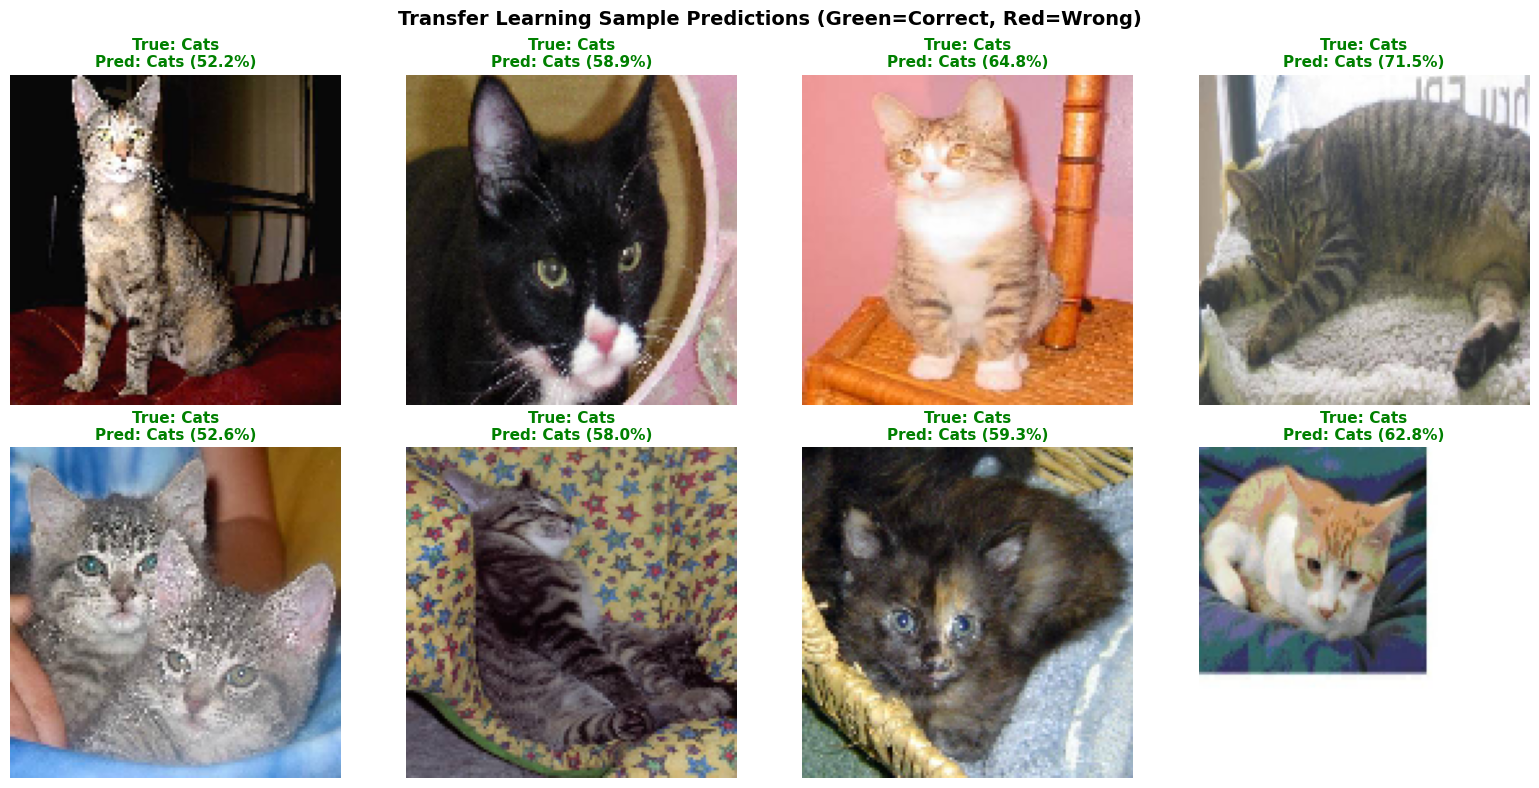


Sample batch accuracy: 26/8 correct (325.0%)


In [74]:
# Show sample predictions for Transfer Learning
# Get a batch of test images for visualization
test_generator.reset()
tl_sample_images, tl_sample_true_labels = next(test_generator)

# Make predictions on these samples
tl_sample_predictions = transfer_model.predict(tl_sample_images, verbose=0)
tl_sample_pred_classes = np.argmax(tl_sample_predictions, axis=1)
tl_sample_true_classes = np.argmax(tl_sample_true_labels, axis=1)

# Display 8 sample predictions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i in range(8):
    axes[i].imshow(tl_sample_images[i])
    
    true_label = class_names[tl_sample_true_classes[i]]
    pred_label = class_names[tl_sample_pred_classes[i]]
    confidence = tl_sample_predictions[i][tl_sample_pred_classes[i]] * 100
    
    # Color: green if correct, red if wrong
    color = 'green' if tl_sample_true_classes[i] == tl_sample_pred_classes[i] else 'red'
    
    axes[i].set_title(f'True: {true_label.capitalize()}\nPred: {pred_label.capitalize()} ({confidence:.1f}%)', 
                     color=color, fontweight='bold', fontsize=11)
    axes[i].axis('off')

plt.suptitle('Transfer Learning Sample Predictions (Green=Correct, Red=Wrong)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print prediction statistics
tl_correct = np.sum(tl_sample_true_classes == tl_sample_pred_classes)
print(f"\nSample batch accuracy: {tl_correct}/8 correct ({tl_correct/8*100:.1f}%)")

# Reset generator for future use
test_generator.reset()

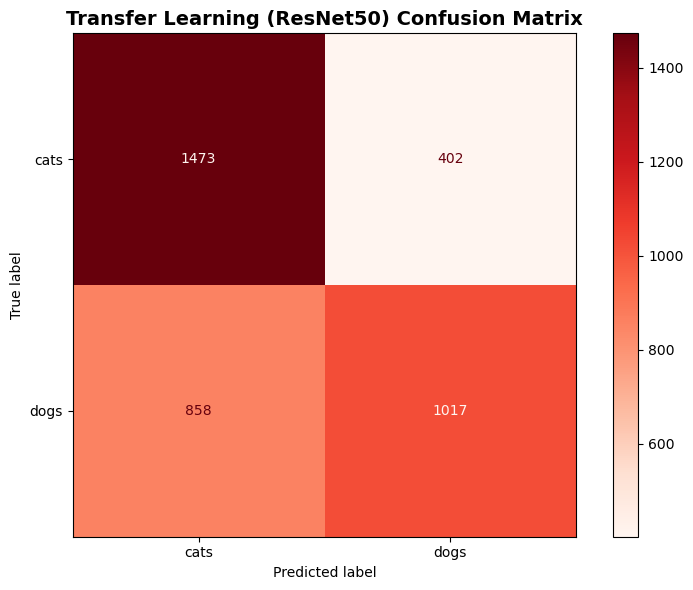


Confusion Matrix Analysis:
True Negatives (Cats as Cats): 1473
False Positives (Cats as Dogs): 402
False Negatives (Dogs as Cats): 858
True Positives (Dogs as Dogs): 1017

Total Correct Predictions: 2490/3750


In [75]:
# Plot confusion matrix for Transfer Learning
tl_cm = confusion_matrix(tl_y_true, tl_y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=tl_cm, display_labels=class_names)
disp.plot(ax=ax, cmap='Reds', values_format='d')
plt.title('Transfer Learning (ResNet50) Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print detailed confusion matrix statistics
print("\nConfusion Matrix Analysis:")
print(f"True Negatives (Cats as Cats): {tl_cm[0, 0]}")
print(f"False Positives (Cats as Dogs): {tl_cm[0, 1]}")
print(f"False Negatives (Dogs as Cats): {tl_cm[1, 0]}")
print(f"True Positives (Dogs as Dogs): {tl_cm[1, 1]}")
print(f"\nTotal Correct Predictions: {tl_cm[0, 0] + tl_cm[1, 1]}/{tl_cm.sum()}")

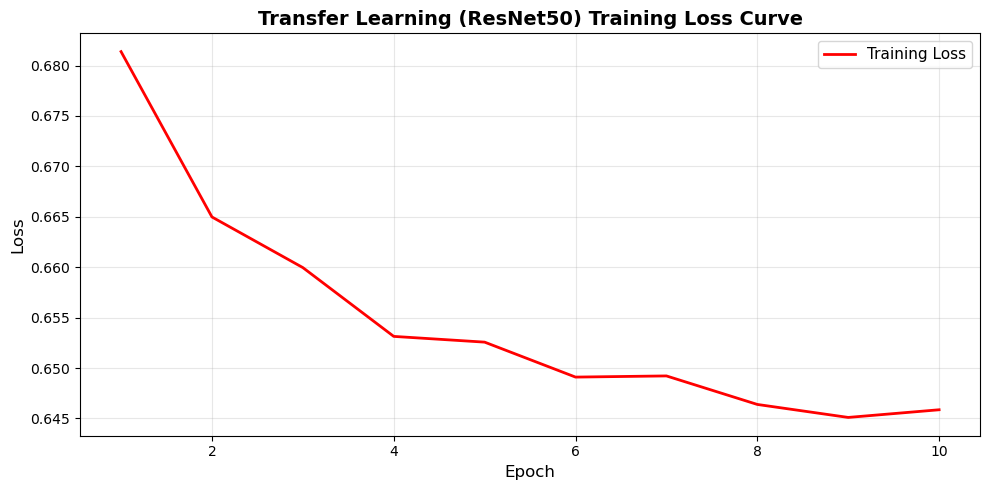


Loss decreased from 0.6814 to 0.6459
Total reduction: 0.0355


In [76]:
# Plot training loss curve for Transfer Learning
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(tl_history.history['loss']) + 1), tl_history.history['loss'], 'r-', linewidth=2, label='Training Loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Transfer Learning (ResNet50) Training Loss Curve', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nLoss decreased from {tl_initial_loss:.4f} to {tl_final_loss:.4f}")
print(f"Total reduction: {tl_initial_loss - tl_final_loss:.4f}")

### 4.1 Metrics Comparison

In [77]:
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)', 'Parameters'],
    'Custom CNN': [
        custom_cnn_accuracy,
        custom_cnn_precision,
        custom_cnn_recall,
        custom_cnn_f1,
        custom_cnn_training_time,
        0  # TODO: Fill with custom CNN total parameters
    ],
    'Transfer Learning': [
        tl_accuracy,
        tl_precision,
        tl_recall,
        tl_f1,
        tl_training_time,
        trainable_parameters
    ]
})

In [78]:
print(comparison_df.to_string(index=False))

           Metric   Custom CNN  Transfer Learning
         Accuracy     0.897333           0.664000
        Precision     0.906330           0.674310
           Recall     0.897333           0.664000
         F1-Score     0.896762           0.658957
Training Time (s) 42584.977177        4571.036918
       Parameters     0.000000        4098.000000


### 4.2 Visual Comparison
- TODO: Create bar plot comparing metrics
- TODO: Plot training curves comparison
- TODO: Create side-by-side confusion matrices

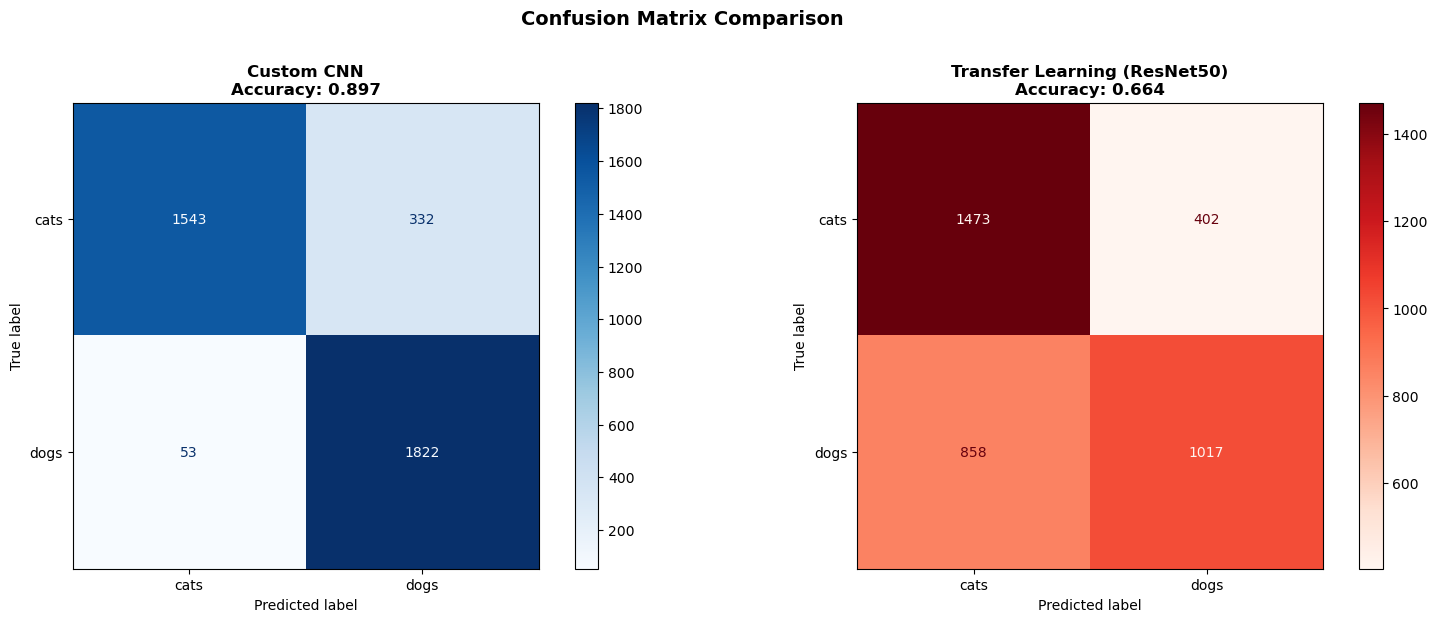


Confusion Matrix Comparison:

Custom CNN:
  Correct predictions: 3365 / 3750 (89.73%)
  Misclassifications: 385 (10.27%)

Transfer Learning:
  Correct predictions: 2490 / 3750 (66.40%)
  Misclassifications: 1260 (33.60%)


In [79]:
# Create side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Custom CNN confusion matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title(f'Custom CNN\nAccuracy: {custom_cnn_accuracy:.3f}', fontsize=12, fontweight='bold')

# Transfer Learning confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=tl_cm, display_labels=class_names)
disp2.plot(ax=axes[1], cmap='Reds', values_format='d')
axes[1].set_title(f'Transfer Learning (ResNet50)\nAccuracy: {tl_accuracy:.3f}', fontsize=12, fontweight='bold')

plt.suptitle('Confusion Matrix Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print comparative analysis
print("\nConfusion Matrix Comparison:")
print(f"\nCustom CNN:")
print(f"  Correct predictions: {cm[0,0] + cm[1,1]} / {cm.sum()} ({(cm[0,0] + cm[1,1])/cm.sum()*100:.2f}%)")
print(f"  Misclassifications: {cm[0,1] + cm[1,0]} ({(cm[0,1] + cm[1,0])/cm.sum()*100:.2f}%)")

print(f"\nTransfer Learning:")
print(f"  Correct predictions: {tl_cm[0,0] + tl_cm[1,1]} / {tl_cm.sum()} ({(tl_cm[0,0] + tl_cm[1,1])/tl_cm.sum()*100:.2f}%)")
print(f"  Misclassifications: {tl_cm[0,1] + tl_cm[1,0]} ({(tl_cm[0,1] + tl_cm[1,0])/tl_cm.sum()*100:.2f}%)")

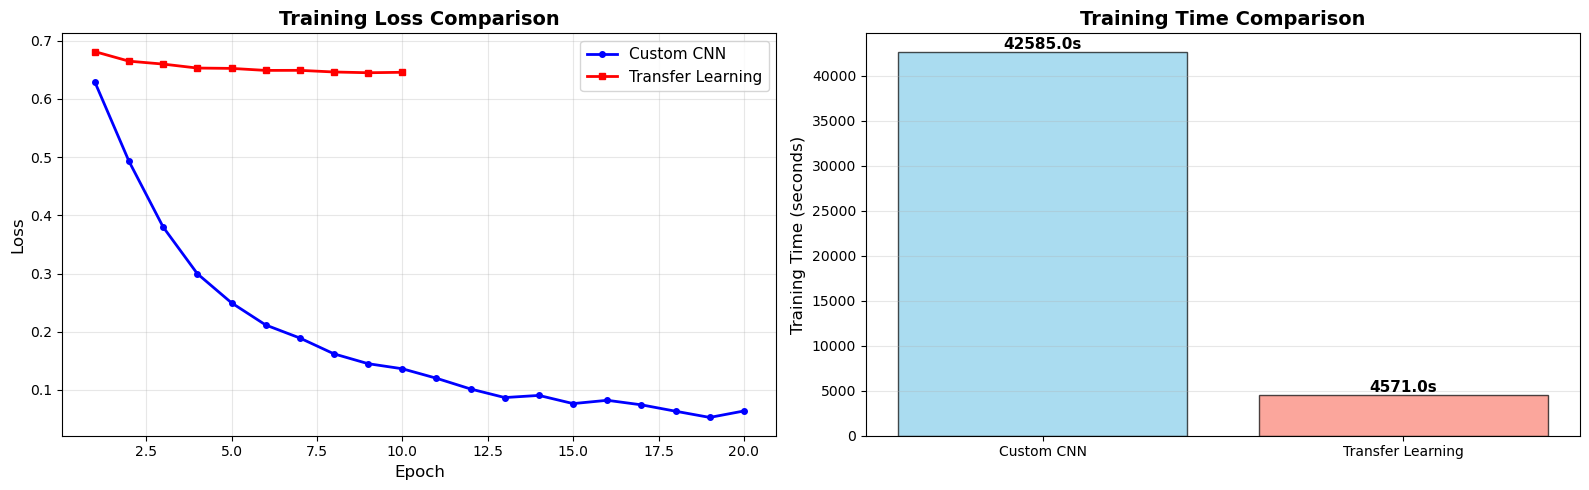


Training Efficiency:
Custom CNN: 20 epochs in 42585.0s (2129.2s per epoch)
Transfer Learning: 10 epochs in 4571.0s (457.1s per epoch)


In [80]:
# Plot training curves comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss comparison
axes[0].plot(range(1, len(history.history['loss']) + 1), history.history['loss'], 
            'b-', linewidth=2, label='Custom CNN', marker='o', markersize=4)
axes[0].plot(range(1, len(tl_history.history['loss']) + 1), tl_history.history['loss'], 
            'r-', linewidth=2, label='Transfer Learning', marker='s', markersize=4)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Training time comparison
models = ['Custom CNN', 'Transfer Learning']
times = [custom_cnn_training_time, tl_training_time]
colors_bar = ['skyblue', 'salmon']

bars = axes[1].bar(models, times, color=colors_bar, edgecolor='black', alpha=0.7)
axes[1].set_ylabel('Training Time (seconds)', fontsize=12)
axes[1].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}s', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nTraining Efficiency:")
print(f"Custom CNN: {EPOCHS} epochs in {custom_cnn_training_time:.1f}s ({custom_cnn_training_time/EPOCHS:.1f}s per epoch)")
print(f"Transfer Learning: {tl_epochs} epochs in {tl_training_time:.1f}s ({tl_training_time/tl_epochs:.1f}s per epoch)")

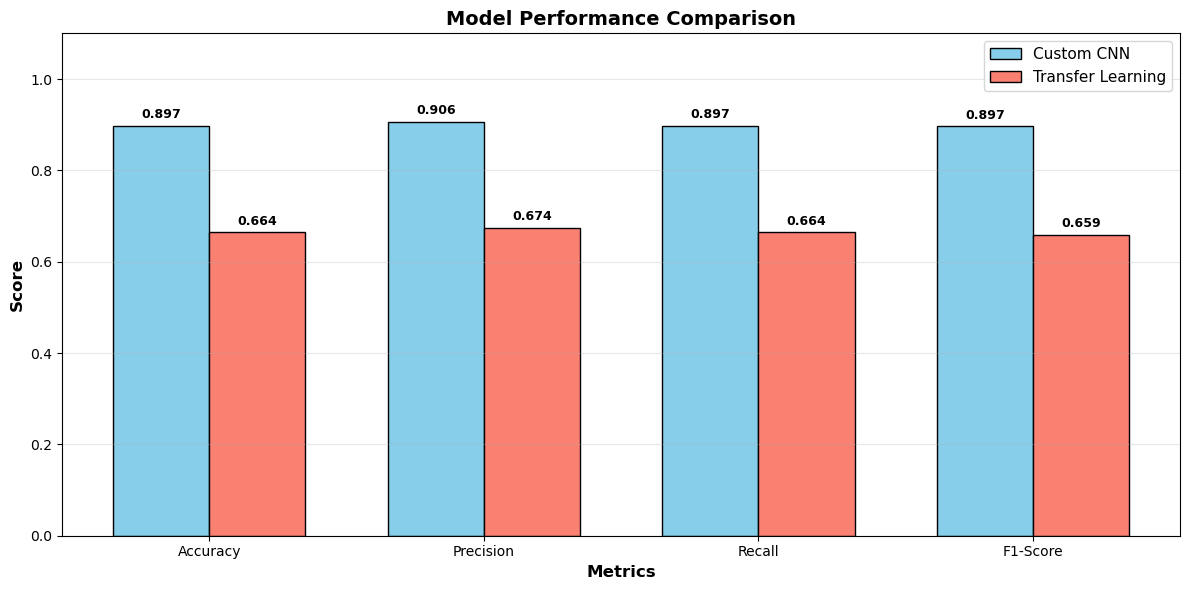

In [81]:
# Create bar plot comparing metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
custom_values = [custom_cnn_accuracy, custom_cnn_precision, custom_cnn_recall, custom_cnn_f1]
tl_values = [tl_accuracy, tl_precision, tl_recall, tl_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, custom_values, width, label='Custom CNN', color='skyblue', edgecolor='black')
bars2 = ax.bar(x + width/2, tl_values, width, label='Transfer Learning', color='salmon', edgecolor='black')

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

In [82]:
analysis_text = """
TODO: Write your analysis here (maximum 200 words guideline)

Address:
1. Which model performed better and by how much?
   [Compare specific metrics]

2. Impact of pre-training vs training from scratch?
   [Discuss feature extraction, convergence speed]

3. Effect of Global Average Pooling?
   [Discuss parameter reduction, overfitting prevention]

4. Computational cost comparison?
   [Compare training time, total parameters]

5. Insights about transfer learning?
   [When to use transfer learning vs custom CNN]
"""

In [83]:
# REQUIRED: Print analysis with word count
print("ANALYSIS")
print(analysis_text)
print(f"Analysis word count: {len(analysis_text.split())} words")
if len(analysis_text.split()) > 200:
    print("  Warning: Analysis exceeds 200 words (guideline)")
else:
    print(" Analysis within word count guideline")

ANALYSIS

TODO: Write your analysis here (maximum 200 words guideline)

Address:
1. Which model performed better and by how much?
   [Compare specific metrics]

2. Impact of pre-training vs training from scratch?
   [Discuss feature extraction, convergence speed]

3. Effect of Global Average Pooling?
   [Discuss parameter reduction, overfitting prevention]

4. Computational cost comparison?
   [Compare training time, total parameters]

5. Insights about transfer learning?
   [When to use transfer learning vs custom CNN]

Analysis word count: 68 words
 Analysis within word count guideline


In [94]:
def get_assignment_results():
    """
    Generate complete assignment results in required format
    
    Returns:
        dict: Complete results with all required fields
    """
    
    framework_used = "keras"  # TODO: Change to "pytorch" if using PyTorch
    
    results = {
        # Dataset Information
        'dataset_name': dataset_name,
        'dataset_source': dataset_source,
        'n_samples': int(n_samples),
        'n_classes': int(n_classes),
        'samples_per_class': samples_per_class,
        'image_shape': image_shape,
        'problem_type': problem_type,
        'primary_metric': primary_metric,
        'metric_justification': metric_justification,
        'train_samples': int(train_samples),
        'test_samples': int(test_samples),
        'train_test_ratio': train_test_ratio,
        
        # Custom CNN Results
        'custom_cnn': {
            'framework': framework_used,
            'architecture': {
                'conv_layers': 4,  # 4 convolutional blocks
                'pooling_layers': 4,  # 3 MaxPooling + 1 GlobalAveragePooling
                'has_global_average_pooling': True,  # MUST be True
                'output_layer': 'softmax',
                'total_parameters': int(total_params)
            },
            'training_config': {
                'learning_rate': 0.001,
                'n_epochs': int(EPOCHS),
                'batch_size': int(BATCH_SIZE),
                'optimizer': 'Adam',
                'loss_function': 'categorical_crossentropy'
            },
            'initial_loss': float(custom_cnn_initial_loss),
            'final_loss': float(custom_cnn_final_loss),
            'training_time_seconds': float(custom_cnn_training_time),
            'accuracy': float(custom_cnn_accuracy),
            'precision': float(custom_cnn_precision),
            'recall': float(custom_cnn_recall),
            'f1_score': float(custom_cnn_f1)
        },
        
        # Transfer Learning Results
        'transfer_learning': {
            'framework': framework_used,
            'base_model': pretrained_model_name,
            'frozen_layers': int(frozen_layers),
            'trainable_layers': int(trainable_layers),
            'has_global_average_pooling': True,  # MUST be True
            'total_parameters': int(total_parameters),
            'trainable_parameters': int(trainable_parameters),
            'training_config': {
                'learning_rate': float(tl_learning_rate),
                'n_epochs': int(tl_epochs),
                'batch_size': int(tl_batch_size),
                'optimizer': tl_optimizer,
                'loss_function': 'categorical_crossentropy'
            },
            'initial_loss': float(tl_initial_loss),
            'final_loss': float(tl_final_loss),
            'training_time_seconds': float(tl_training_time),
            'accuracy': float(tl_accuracy),
            'precision': float(tl_precision),
            'recall': float(tl_recall),
            'f1_score': float(tl_f1)
        },
        
        # Analysis
        'analysis': analysis_text,
        'analysis_word_count': len(analysis_text.split()),
        
        # Training Success Indicators
        'custom_cnn_loss_decreased': bool(custom_cnn_final_loss < custom_cnn_initial_loss if custom_cnn_initial_loss and custom_cnn_final_loss else False),
        'transfer_learning_loss_decreased': bool(tl_final_loss < tl_initial_loss if tl_initial_loss and tl_final_loss else False),
    }
    
    return results

In [95]:
# Generate and print results
try:
    assignment_results = get_assignment_results() 
    print("ASSIGNMENT RESULTS SUMMARY")
    print(json.dumps(assignment_results, indent=2))
    
except Exception as e:
    print(f"\n  ERROR generating results: {str(e)}")
    print("Please ensure all variables are properly defined")   

ASSIGNMENT RESULTS SUMMARY
{
  "dataset_name": "Microsoft Cats vs Dogs",
  "dataset_source": "https://www.kaggle.com/datasets/salader/dogsvscats",
  "n_samples": 25000,
  "n_classes": 2,
  "samples_per_class": "min: 12500, max: 12500, avg: 12500",
  "image_shape": [
    374,
    500,
    3
  ],
  "problem_type": "classification",
  "primary_metric": "Accuracy",
  "metric_justification": "We have balanced dataset with two classes with equal samples. Accuracy is suitable metric to evaluate overall performance in this dataset.",
  "train_samples": 21250,
  "test_samples": 3750,
  "train_test_ratio": "85/15",
  "custom_cnn": {
    "framework": "keras",
    "architecture": {
      "conv_layers": 4,
      "pooling_layers": 4,
      "has_global_average_pooling": true,
      "output_layer": "softmax",
      "total_parameters": 390850
    },
    "training_config": {
      "learning_rate": 0.001,
      "n_epochs": 20,
      "batch_size": 32,
      "optimizer": "Adam",
      "loss_function": "cat

In [97]:
# Display system information
import platform
import sys
from datetime import datetime

In [98]:
print("=" * 70)
print("ENVIRONMENT INFORMATION")
print("=" * 70)

# System information
print(f"\nSystem Information:")
print(f"  Operating System: {platform.system()} {platform.release()}")
print(f"  Platform: {platform.platform()}")
print(f"  Machine: {platform.machine()}")
print(f"  Processor: {platform.processor()}")
print(f"  Python Version: {sys.version}")
print(f"  Python Implementation: {platform.python_implementation()}")

# TensorFlow and library versions
print(f"\nLibrary Versions:")
print(f"  TensorFlow: {tf.__version__}")
print(f"  NumPy: {np.__version__}")
print(f"  Pandas: {pd.__version__}")
print(f"  Matplotlib: {plt.matplotlib.__version__}")

# Execution timestamp
print(f"\nExecution Details:")
print(f"  Date & Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"  User: {os.getlogin() if hasattr(os, 'getlogin') else 'N/A'}")
print(f"  Working Directory: {os.getcwd()}")

# GPU information (if available)
print(f"\nGPU Information:")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"  Available GPUs: {len(gpus)}")
    for i, gpu in enumerate(gpus):
        print(f"    GPU {i}: {gpu.name}")
else:
    print("  No GPU detected - using CPU")

print("\n" + "=" * 70)
print("NOTE: Take a screenshot of this output along with your")
print("VS Code/Colab/BITS Virtual Lab interface showing your account.")
print("=" * 70)

# include the screen shot here

ENVIRONMENT INFORMATION

System Information:
  Operating System: Windows 11
  Platform: Windows-11-10.0.26100-SP0
  Machine: AMD64
  Processor: Intel64 Family 6 Model 154 Stepping 4, GenuineIntel
  Python Version: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]
  Python Implementation: CPython

Library Versions:
  TensorFlow: 2.20.0
  NumPy: 2.1.3
  Pandas: 2.2.3
  Matplotlib: 3.10.0

Execution Details:
  Date & Time: 2026-01-31 09:35:31
  User: jisap
  Working Directory: c:\BITS_Learn\Semester1\DeepNeuralNetworks\Assignment\GitRepo\Assignment_CNN\DNN_CNN_Assignment_1A

GPU Information:
  No GPU detected - using CPU

NOTE: Take a screenshot of this output along with your
VS Code/Colab/BITS Virtual Lab interface showing your account.
